#Predicting Batter/Pitcher Matchups in Major League Baseball
##An Exploration of Collaborative Filtering Models and their Applications to Sports Statistics


###By: Chris Allen, Ben Cook, Ali Forelli, and Tori Machado (Harvard University)
###Harvard CS 109 - Fall 2015

#0. Introduction
##What problem are we trying to solve?

Statistical analysis is often used on past baseball statistics to improve knowledge and insight on the sport. Extensive research has been done on baseball statistics because of baseball’s reliance on numbers and data to help analyze the game. Started by works from notable baseball writers such as Bill James and the Society of American Baseball Research (http://sabr.org/about), analytics has become very big in baseball the last few years, with elaborate data collected on both team and individual player statistics. 

In this project, we attempt to use previous recorded data about a batter and a pitcher to predict a batter’s batting average when facing a pitcher that he’s never seen before. While most statistical analysis of baseball statistics are designed to assist front office members of baseball organizations with choices on players to sign and trade for, our analysis could prove very useful for baseball managers in the middle of a game situation itself. Baseball statistics databases such as MLB.com in the figure below have specific data for every player against any pitcher in the game that he has faced. For example, David Ortiz has faced multiple pitchers on the New York Yankees before, so the Red Sox manager knows how successful Ortiz is against those pitchers, and therefore has some idea about what to expect when Ortiz will face those pitchers again. But what if the Yankees bring in a pitcher that Ortiz has never faced? These databases do not have any data for those batter-pitcher matchups, nor do they have any predictions for the statistics of those matchups. 

![matchupexample](Images/MLBmatchupexample.png)

Imagine, in a World Series championship game, the defensive team bringing in a new relief pitcher. The offensive team has the tying run on third base, and has two options: the manager can choose the batter scheduled to bat, or bring in a pinch hitter. While many other factors affecting the manager’s choice come into play, past success against the new pitcher is certainly considered. The decision is a lot easier if the manager knows how successful each batter has against the new pitcher. But if neither player has faced this pitcher before, then how can the manager decide which batter will be more likely to drive in the winning run? That is, how can the manager predict who will have a better batting average or on-base percentage against the new pitcher? 

We attempt to answer this question using a few different methods. We first calculate a sample based average baseline model. Then we utilize collaborative filtering using kNN; in other words, if we have a batter that has never faced a pitcher before, we first find the k most similar pitchers to the unknown pitcher that the batter has faced, and use that batter’s success against those pitchers to predict how well the batter does against this new pitcher. Then we use data from all matchups that a batter has with any pitchers in a ridge regression to predict the batting average. Finally, we combine the results from both of these models in an “ensemble” method using a stacked regression. 

##An Overview of Baseball Statistics and Abbreviations

#1. Data Collection

##Lahman Database

The [Lahman Database](http://www.seanlahman.com/baseball-archive/statistics/) is a project run by journalist/author Sean Lahman. It includes complete statistics on Major League Baseball pitchers and batters from the late 1800s until the present day, as well as on managers, teams, salaries, and awards. All data is freely available in a variety of forms.

We downloaded the comma-delimited version of the database which includes statistics through the end of the 2014 professional season. *Data for 2015 was not available at the time of the project.*

We relied on two datasets in the Lahman Database: **Master.csv** and **Batting.csv**:

**Batting.csv**: Contains year-by-year batting statistics on every MLB player since 1871. A selection is shown below. We used this dataset to compile a list of all batters who had plate appearances in the time period 2004 - 2014.

![Batting.csv](Images/Batting.png)

**Master.csv**: Contains summary information on MLB players, including their names, dates of birth, and IDs in other major databases. We used this dataset to gather the Retrosheet IDs (see below) for the batter chosen from the Batting.csv file.

![Master.csv](Images/Master.png)



In [5]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import json
from bs4 import BeautifulSoup
import sys
from scipy import stats
from sklearn.cross_validation import *

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

Load the Lahman database files

In [6]:
master = pd.read_csv('data/lahman/Master.csv')
all_batting = pd.read_csv('data/lahman/Batting.csv')

In [8]:
pitching = pd.read_csv('data/lahman/Pitching.csv')

In [10]:
smalldf = pd.read_csv('data/small.csv')

In [13]:
pitcherIDs = smalldf['pID'].unique()#RetroIDs
L_pitcherIDs = [retro_to_lah[name] for name in pitcherIDs]

In [33]:
mask = np.in1d(pitching.playerID, L_pitcherIDs)

In [40]:
grouped =  pitching.groupby('playerID').sum().reset_index()
mask = np.in1d(grouped.playerID, L_pitcherIDs)
a = grouped[mask]

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aardsda01,16069,8,15,17,298,0,0,0,69,919,271,144,35,169,305,2.093,42.05,19,11,15,1,1346,132,152,17,10,NaN
7,abbotji01,21932,12,87,108,263,254,31,6,0,5022,1779,791,154,620,888,2.370,49.46,30,53,32,11,7211,5,880,NaN,NaN,NaN
9,abbotpa01,23977,13,43,37,162,112,1,0,0,2162,682,394,101,393,496,2.677,66.14,17,37,21,0,3187,17,421,8,12,NaN
20,accarje01,20086,12,10,20,262,0,0,0,38,854,288,136,24,111,205,3.004,53.49,16,10,9,2,1222,115,143,5,13,NaN
21,aceveal01,14077,7,31,16,204,15,0,0,29,1141,333,162,48,129,282,1.689,28.29,6,5,28,6,1599,91,172,6,13,1
22,acevejo01,10015,5,18,25,104,59,1,0,1,1105,420,235,71,113,253,1.360,27.75,14,9,12,2,1628,11,246,14,17,NaN
23,aceveju01,19999,12,28,40,367,34,0,0,53,1710,597,274,72,226,350,2.283,45.08,34,20,28,4,2488,165,316,11,12,NaN
25,ackerji01,23850,14,33,49,467,32,0,0,30,2713,918,399,82,329,482,3.190,47.52,40,31,32,2,3868,159,447,NaN,NaN,NaN
31,acostma01,12057,6,13,13,233,0,0,0,9,744,234,110,30,117,219,1.459,23.05,10,14,8,0,1070,78,122,9,5,NaN
43,adamsmi03,22103,12,21,20,408,0,0,0,4,1222,316,109,33,126,409,2.457,35.99,12,7,6,0,1653,60,122,13,6,2


Develop a dataset of "Modern" batters, defined as those who had plate appearances from 2004 onwards

In [7]:
lah_to_retro = dict(zip(master['playerID'], master['retroID'])) #key=lahmanID, value=retroID
retro_to_lah = dict(zip(master['retroID'], master['playerID'])) #reverse of above

retro_ids = [lah_to_retro[name] for name in all_batting['playerID']] 
all_batting['retroID'] = retro_ids

is_modern_batter = (all_batting['yearID'] >= 2004)
batter_ids = np.unique(all_batting['retroID'][is_modern_batter]) #array of unique Retrosheet IDs

modern_mask = np.array([name in batter_ids for name in all_batting['retroID']])
batting = all_batting[modern_mask] #data frame with batting stats of "modern" batters

How many unique batters appeared between 2004 and 2014?

In [4]:
len(batter_ids)

3561

##Retrosheet Databases

The [Retrosheet](http://www.retrosheet.org/site.htm) "Encyclopedia" is a fantastic complement to the Lahman Database. It contains a huge assortment of statistics and other data which are difficult to find other places, such as individual game play-by-play records, records of player trades and signings, and even ejections. Players are identified with a unique ID, formatted as 5 lower-case letters and 3 numbers: "abcde123". The first four letters are the beginning of the player's *last name*, the fifth is the first letter of the player's *first name*, and the final 3 digits are used to separate repeat names. For example, [Sammy Sosa](https://en.wikipedia.org/wiki/Sammy_Sosa)'s ID is: "sosas001".

###Batter-Pitcher Matchups

Of most interest to us is the Retrosheet collection of batter-pitcher matchups. For all batters from 1940 onwards, Retrosheet has recorded their statistics (hits, plate appearances, strike-outs, etc.) against each pitcher they faced. This data will be at the heart of our analysis that follows. 

####Important Distinction:
**The Retrosheet pages only include matchups where a batter had at last *4* plate appearances against a pitcher. So, totaling a player's statistics from the Retrosheet matchups will *NOT* equal their career totals as given by the Lahman Database.**

Unfortunately, this data is not available in an easily-downloadable format. Instead, each batter has a unique HTML webpage with the statistics listed. The URLs for each player's webpage follows a standard format:

http:<span></span>//www.retrosheet.org/boxesetc/**L**/MU0_**ID**.htm .

Here, **L** is the player's Last Initial (capitalized), and **ID** is the player's Retrosheet ID. Pitchers also have matchup pages, which lists the statistics of all batters who faced them. These pages have an identical format, except for replacing "MU0" with "MU1". 

Here is a sample from the matchup page for Sammy Sosa ("sosas001", mentioned above): http://www.retrosheet.org/boxesetc/S/MU0_sosas001.htm

![Sammy Sosa Matchup Page](Images/Sosa_Matchup.png)

As shown in the source snippet, the actual data is organized in a fairly unstructured way, simply separated into many lines, with values separated by arbitrary spacing and column-title lines thrown in regularly.

###Scraping the Retrosheet Pages

From the Lahman Database, we have a list of Retrosheet IDs for all "Modern" batters. Using Python's [requests](http://docs.python-requests.org/en/latest/) package, we scrape the Retrosheet Matchup pages for all "Modern" batters, and use [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse the webpages into useable data.

In [9]:
def retro_url(retroID):
    """
    Given a retroID (Retrosheet ID for a batter), return the formatted URL for that batter's matchup page.
    """
    return 'http://www.retrosheet.org/boxesetc/%s/MU0_%s.htm'%(retroID[0].upper(), retroID)

Using the list of "Modern" batters, scrape all the available Retrosheet matchup pages, and store the resulting text. For ~3000 batters, the process below takes around 10-15 minutes. **Note:** as discussed below, many of the "Modern" batters do not have Retrosheet matchup pages, so the request module returns a 404 error, which we account for.

In [10]:
def scrape_pages(batter_ids, cache=True):
    """
    Given a list of batter_ids, find all the retrosheet pitcher matchup pages for each batter.
    Copy the text from each page, and store in dictionary keyed by batterID. Some batters may not be found,
    so this also records those that are/aren't found.
    
    This process takes a long time, so it caches the results to disk throughout. Prints out the progress.
        
    input
    --------
    batter_ids: iterable list or array of retrosheet player IDs
    
    output
    --------
    batter_pages: dictionary of text for all matchup pages found, keyed by batterID
    found: list of batterIDs for which matchup pages were found
    not_found: list of batterIDs for which no matchup pages could be found
    """
    
    batter_pages = {} #key: retroID, value: text of matchup page
    found = []
    not_found = []
    
    for i, batter in enumerate(batter_ids):
        time.sleep(.2) #Don't overload the Retrosheet servers
        url = retro_url(batter)
        if (i%100==0):
            print('%d of %d'%(i, len(batter_ids)))
            if cache:
                f = open('data/batter_pages.json', 'w') #cache the results to disk as we go, in case this fails
                json.dump(batter_pages, f)
                f.close()
        req=requests.get(url)
        if req.status_code==200:
            batter_pages[batter] = req.text
            found.append(batter)
        else: #Some batters with very few at bats will not have pages.
            not_found.append(batter)
    return batter_pages, found, not_found

In [ ]:
#%%time
# batter_pages, found, not_found = scrape_pages(batter_ids)

In [ ]:
# #Store the results to disk
# f = open('data/batter_pages.json', 'w')
# json.dump(batter_pages, f)
# f.close()

# f = open('data/found.json', 'w')
# json.dump(found, f)
# f.close()

# f = open('data/not_found.json', 'w')
# json.dump(not_found, f)
# f.close()

We have stored the results to disk, so it can be easily reloaded without having to repeat the scraping process, which takes a long time

In [11]:
#Restore the results from disk
with open("data/batter_pages.json", "r") as f:
    batter_pages = json.load(f)
with open("data/found.json", 'r') as f:
    found = json.load(f)
with open("data/not_found.json", 'r') as f:
    not_found = json.load(f)

How many batters did we find matchup pages for? (All 3 values should be equal)

In [12]:
print len(batter_pages), len(found), len(batter_ids) - len(not_found)

1864 1864 1864


We found over 3500 players from the Lahman Database, but only around 1800 of them had pages on Retrosheet. Why did we miss so many players? Turns out that players with $N<100$ ABs may often not have a matchup page. Using the players' career totals from the Lahman Database:

In [33]:
ABs = batting.groupby('retroID')['AB'].sum() #Total statistics from the Lahman Database, for each "Modern" player
AB_missed = np.array([ABs[name] for name in not_found])
AB_found = np.array([ABs[name] for name in found])

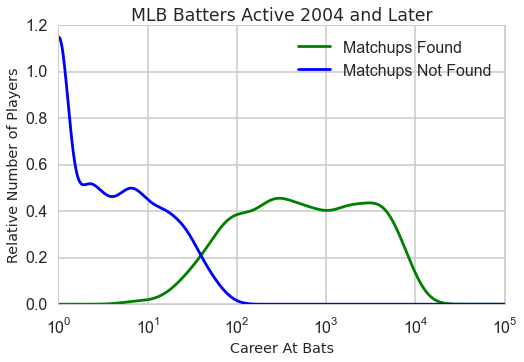

In [168]:
#kde_ABs = stats.gaussian_kde(np.log10(ABs+1)) #make a KDE of density of log AB (+1 because many players with zero AB)
kde_missed = stats.gaussian_kde(np.log10(AB_missed + 1))
kde_found = stats.gaussian_kde(np.log10(AB_found+1))

fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 5, 1000)
#axis.plot(10**x, kde_found(x)+kde_missed(x), 'k-', label='All \"Modern\" Batters')
axis.plot(10**x, kde_found(x), 'g-', label='Matchups Found')
axis.plot(10**x, kde_missed(x), 'b-', label='Matchups Not Found')
axis.set_xscale('log')
axis.set_xlabel('Career At Bats', fontsize='x-large'), axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.set_title('MLB Batters Active 2004 and Later', fontsize='xx-large')
axis.legend(loc=0)

Ok. While there is a large population of players with missing matchup data, our sample is essentially 100% complete for batters who had at least 100 At Bats, who are the batters with enough statistics for us to concern ourselves with, anyways.

###Parse the Retrosheet HTML pages into a Matchup Dataframe

The pipeline below will take the dictionary of HTML text from each webpage, and convert it into a list of matchup statistics. Each element of the list is a dictionary holding the statistics for one batter-pitcher matchup.

In [38]:
def stats_parse(line):
    """
    Takes a line, which is a length-15 list of statistics for each matchup:
    R/L, AB, H, 2B, 3B, HR, BB, IBB, SO, HBP, SH, SF, AVG, OBP, SLG
    
    Returns a list with quantities: [AB, PA, H, TB, W, SO, SAC, RL]
    AB: At Bats
    PA: Plate Appearances (AB + W)
    H: Hits
    TB: Total Bases (H + 2*2B + 3*3B + 4*HR)
    W: Walks (BB + IBB + HBP)
    SO: Strike Outs
    SAC: Sacrifices (SH + SF)
    RL: Righty/Lefty pitcher
    """
    RL = line[0] #R/L handed pitcher
    AB = int(line[1]) #At Bats
    H = int(line[2]) #Hits
    TB = int(line[2]) + 2*int(line[3]) + 3*int(line[4]) + 4*int(line[5]) #Total Bases
    W = int(line[6]) + int(line[7]) + int(line[9]) #Walks (BB + IBB + HBP)
    PA = AB + W #Plate Appearances
    SO = int(line[8]) #Strikeouts 
    SAC = int(line[10]) + int(line[11]) #Sacrifices
    return [AB, PA, H, TB, W, SO, SAC, RL]

def parse_pages(pages, batterIDs=None):
    """
    Takes a dictionary pages with retroIDs of batters as keys,
    and the text of that batter's Retrosheet matchup sheet as values.
    Takes an optional array of retroIDs for batters.
    
    Returns a list of one dictionary for each batter-pitcher matchup, with fields:
    pID: pitcher ID
    bID: batter ID
    matchID: matchup ID, formatted as bID_pID
    AB: number of At Bats
    PA: number of Plate Appearances
    H: number of Hits
    SLUG: slugging value (H + 2*2B + 3*3B + 4*HR)
    W: number of Walks
    SO: number of Strike Outs
    SAC: number of Sac Flies and Sac Bunts
    """
    matchup_list = []
    
    if batterIDs is None:
        batterIDs = pages.keys()
    
    for batterID in batterIDs:
        text = pages[batterID]
        if text=='':
            continue
        soup = BeautifulSoup(pages[batterID], 'html.parser')
        data = soup.find_all('pre')[2]
        for i in np.arange(1, len(data.contents), 2):
            pitcherID = data.contents[i].get('href').split('/')[-1].split('.')[0].lstrip('P') #8-char retroID
            assert(len(pitcherID)==8)
            stats = data.contents[i+1].split('\n')[0].split() #list of stats values
            assert(len(stats) == 15)
            stats = stats_parse(stats)
            fields = ['AB', 'PA', 'H', 'TB', 'W', 'SO', 'SAC', 'RL']
            matchup = dict(zip(fields, stats))
            matchup['pID'] = pitcherID
            matchup['bID'] = batterID
            matchup['matchID'] = '%s_%s'%(batterID, pitcherID)

            matchup_list.append(matchup)
    return matchup_list

In [40]:
# %%time
# matchup_list = parse_pages(batter_pages)

CPU times: user 27.7 s, sys: 430 ms, total: 28.1 s
Wall time: 28.3 s


How many total matchups found?

In [41]:
len(matchup_list)

248420

Store and reload the results for later use.

In [42]:
f = open('data/matchups_2004.json', 'w')
json.dump(matchup_list, f)
f.close()

This step processes the list of matchups into a Pandas Dataframe.

In [57]:
matchup_df = pd.read_json("data/matchups_2004.json")

##Calculate more matchup-specific and player-total statistics

In [58]:
#Matchup-specific totals
matchup_df['AVG'] = matchup_df['H']/matchup_df['AB']
matchup_df['OBP'] = (matchup_df['H'] + matchup_df['W'])/matchup_df['PA']
matchup_df.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.200000,0.200000
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.000000,0.000000
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,felds001,0.000000,0.000000
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,grays001,0.333333,0.333333
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,adamt001,0.000000,0.250000


Overall averages are totalled by batter ("ov\_") and by pitcher ("ovp\_")

In [60]:
batter_sums = matchup_df.groupby('bID').sum() #by-batter totals for H, AB, etc.
batter_matchups = matchup_df.groupby('bID')['AB'].count() #Number of pitchers seen by each player
batter_sums['FACED'] = batter_matchups
#Gives the overall average and OBP of batters
batter_sums['AVG'] = batter_sums['H']/batter_sums['AB']
batter_sums['OBP'] = (batter_sums['H'] + batter_sums['W'])/batter_sums['PA']
batter_sums['SO_PCT'] = batter_sums['SO']/batter_sums['PA']
batter_sums['W_PCT'] = batter_sums['W']/batter_sums['PA']
batter_sums['H_PCT'] = batter_sums['H']/batter_sums['PA']

batter_df = pd.DataFrame(batter_sums).reset_index()
rename = dict(zip(batter_df.columns, 'ov_'+batter_df.columns))
rename['bID'] = 'bID'
batter_df.rename(columns=rename, inplace=True)

batter_df.head()

,bID,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT
0,abada001,7,1,8,0,1,1,1,0.142857,0.250000,2,0.125000,0.125000,0.125000
1,abbop001,4,0,4,0,1,0,0,0.000000,0.000000,1,0.250000,0.000000,0.000000
2,aberb001,621,148,664,9,70,231,43,0.238325,0.287651,85,0.105422,0.064759,0.222892
3,aberr001,145,45,153,1,30,84,8,0.310345,0.346405,29,0.196078,0.052288,0.294118
4,abreb001,7568,2193,8980,74,1659,4418,1412,0.289773,0.401448,684,0.184744,0.157238,0.244209


In [62]:
pitcher_sums=matchup_df.groupby('pID').sum()
pitcher_matchups = matchup_df.groupby('pID')['AB'].count()
pitcher_sums['FACED'] = pitcher_matchups
#Gives the overall strike out, walk and hit percentage of pitchers
pitcher_sums['SO_PCT'] = pitcher_sums['SO']/pitcher_sums['PA']
pitcher_sums['W_PCT'] = pitcher_sums['W']/pitcher_sums['PA']
pitcher_sums['H_PCT'] = pitcher_sums['H']/pitcher_sums['PA']
pitcher_sums['AVG'] = pitcher_sums['H']/pitcher_sums['AB']
pitcher_sums['OBP'] = pitcher_sums['W_PCT']+pitcher_sums['H_PCT']

pitcher_df = pd.DataFrame(pitcher_sums).reset_index()
rename = dict(zip(pitcher_df.columns, 'ovp_'+pitcher_df.columns))
rename['pID'] = 'pID'
pitcher_df.rename(columns=rename, inplace=True)

pitcher_df.head()

,pID,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,aardd001,564,131,662,11,142,261,98,0.232270,0.345921,119,0.214502,0.148036,0.197885
1,aased001,27,6,33,1,5,10,6,0.222222,0.363636,6,0.151515,0.181818,0.181818
2,abadf001,259,70,282,1,51,116,23,0.270270,0.329787,58,0.180851,0.081560,0.248227
3,abbog001,10,1,12,0,0,1,2,0.100000,0.250000,1,0.000000,0.166667,0.083333
4,abboj001,1225,364,1352,20,132,662,127,0.297143,0.363166,79,0.097633,0.093935,0.269231


The new matchup Dataframe is as follows. Each matchup is represented by one row, and each row has both the matchup-specific stats (like "AB", "H", etc.) as well as the overall totals for the batter ("ov_AB", "ov_SO", etc.) and for the pitcher ("ovp_AB", 'ovp_SO", etc.).

Note that these "totals" are calculated as the totals for all listed matchups (PA >~ 4), so these total stats will be slightly different than the career totals from the Lahman Database 

In [184]:
bigdf = matchup_df.copy()
for df in [batter_df, pitcher_df]:
    bigdf = bigdf.merge(df, how='left')
    
bigdf.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.200000,0.200000,5,1,5,0,2,1,0,0.200000,0.200000,1,0.400000,0.00000,0.200000,1405,357,1502,13,297,674,97,0.254093,0.302264,188,0.197736,0.064581,0.237683
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.000000,0.000000,3,0,3,1,2,0,0,0.000000,0.000000,1,0.666667,0.00000,0.000000,5014,1260,5776,91,1023,2335,762,0.251296,0.350069,356,0.177112,0.131925,0.218144
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,felds001,0.000000,0.000000,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,3602,979,3985,53,556,1835,383,0.271793,0.341782,347,0.139523,0.096110,0.245671
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,grays001,0.333333,0.333333,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,793,177,864,9,189,289,71,0.223203,0.287037,110,0.218750,0.082176,0.204861
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,adamt001,0.000000,0.250000,411,66,424,62,143,84,13,0.160584,0.186321,72,0.337264,0.03066,0.155660,2076,566,2346,34,399,937,270,0.272640,0.356351,243,0.170077,0.115090,0.241262


In [185]:
bigdf.to_csv("data/big.csv", index=False)

#2. Exploratory Data Analysis

In [210]:
get_one = np.random.choice

In [178]:
#Reload the dataframe from this point, if desiring to start from this point.
big_df = pd.read_csv("data/big.csv")

In [187]:
print("Overall details of our dataframe:")
print('Total matchups: %d'%(len(bigdf)))
print('Unique batters: %d'%(len(batter_df)))
print('Unique pitchers: %d'%(len(pitcher_df)))
print('Coverage fraction: %.3f (Number of all possible matchups which were encountered)'%(float(len(bigdf)) / (len(batter_df)*len(pitcher_df))))

Overall details of our dataframe:
Total matchups: 248420
Unique batters: 1864
Unique pitchers: 2684
Coverage fraction: 0.050 (Number of all possible matchups which were encountered)


How many times has each batter/pitcher seen each other? (PAs)

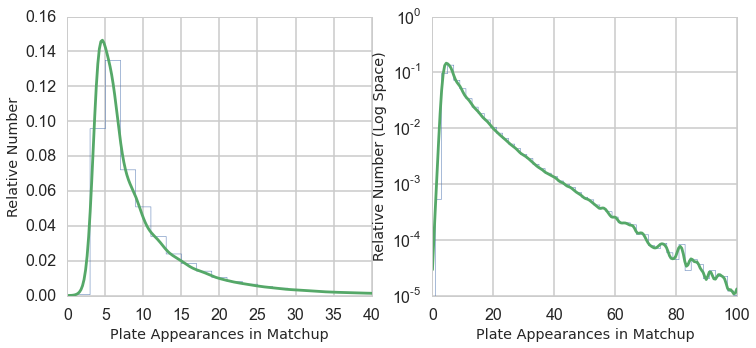

In [188]:
kde_times_seen = stats.gaussian_kde(bigdf['PA'])

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
axis=axes[0]
axis.hist(bigdf['PA'], normed=True, bins=80, histtype='step')
x = np.linspace(0, 40, 200)
axis.plot(x, kde_times_seen(x))
axis.set_xlim([0, 40])
axis.set_xlabel('Plate Appearances in Matchup', fontsize='x-large')
axis.set_ylabel('Relative Number', fontsize='x-large')

axis=axes[1]
axis.hist(bigdf['PA'], normed=True, bins=80, histtype='step')
x = np.linspace(0, 100, 200)
axis.plot(x, kde_times_seen(x))
axis.set_xlim([0, 100])
axis.set_yscale('log')
axis.set_xlabel('Plate Appearances in Matchup', fontsize='x-large')
axis.set_ylabel('Relative Number (Log Space)', fontsize='x-large')

How many pitchers/batters have each player faced?

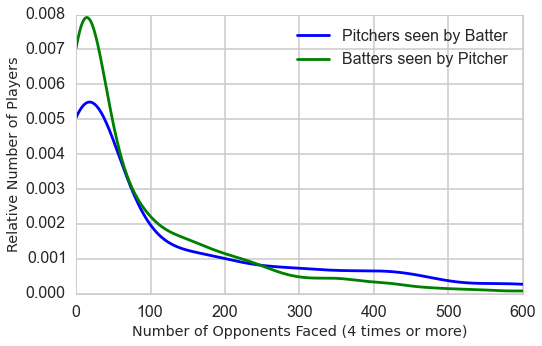

In [211]:
kde_b_matchups = stats.gaussian_kde(bigdf.groupby('bID').ov_FACED.agg(get_one))
kde_p_matchups = stats.gaussian_kde(bigdf.groupby('pID').ovp_FACED.agg(get_one))

fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 600, 500)
plt.plot(x, kde_b_matchups(x), 'b-', label='Pitchers seen by Batter')
plt.plot(x, kde_p_matchups(x), 'g-', label='Batters seen by Pitcher')
axis.set_xlabel('Number of Opponents Faced (4 times or more)', fontsize='x-large')
axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.legend(loc=0)

It seems that a large fraction of batters faced fewer than 100 pitchers, and vice-versa.

What does the distribution of AVG look like across all batters/pitchers?

Mean batter AVG: 0.220
Median batter AVG: 0.246
Mean batter OBP: 0.277
Median batter OBP: 0.307

Mean pitcher AVG: 0.280
Median pitcher AVG: 0.275
Mean pitcher OBP: 0.363
Median pitcher OBP: 0.356


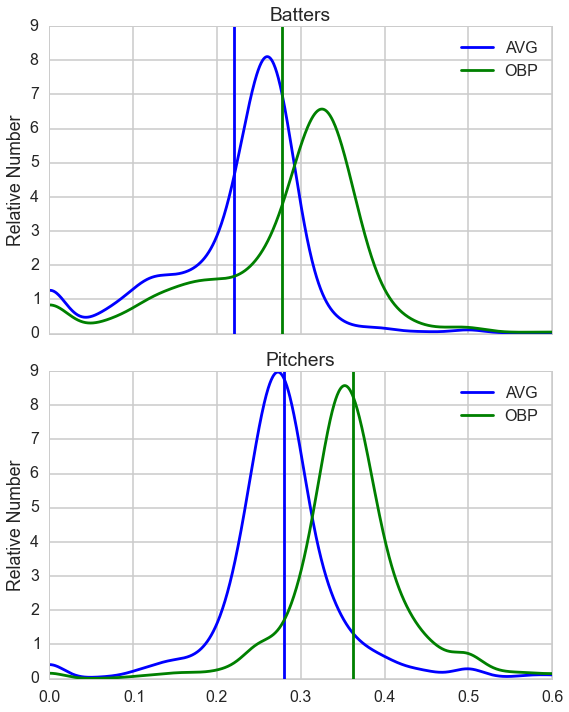

In [212]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=2, sharex=True)
axis=axes[0]
AVG, OBP = bigdf.groupby('bID')['ov_AVG'].agg(get_one), bigdf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG')
axis.axvline(AVG.mean(), color='b', ls='-')
print('Mean batter AVG: %.3f'%(AVG.mean()))
print('Median batter AVG: %.3f'%(AVG.median()))

axis.plot(x, kde_O(x), 'g-', label='OBP')
axis.axvline(OBP.mean(), color='g', ls='-')
print('Mean batter OBP: %.3f'%(OBP.mean()))
print('Median batter OBP: %.3f\n'%(OBP.median()))
axis.set_title("Batters")
axis.set_ylabel('Relative Number')
axis.legend()

axis=axes[1]
AVG, OBP = bigdf.groupby('pID')['ovp_AVG'].agg(get_one), bigdf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG')
axis.axvline(AVG.mean(), color='b', ls='-')
print('Mean pitcher AVG: %.3f'%(AVG.mean()))
print('Median pitcher AVG: %.3f'%(AVG.median()))

axis.plot(x, kde_O(x), 'g-', label='OBP')
axis.axvline(OBP.mean(), color='g', ls='-')
print('Mean pitcher OBP: %.3f'%(OBP.mean()))
print('Median pitcher OBP: %.3f'%(OBP.median()))
axis.set_title("Pitchers")
axis.set_ylabel('Relative Number')
axis.legend()
plt.tight_layout()

#3. Shrinking the Dataset

##Remove matchups and players with low statistics

In [213]:
#Reload dataset from here, in case want to begin from this part of the code
bigdf = pd.read_csv("data/big.csv")
dftouse=bigdf.copy()
dftouse.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.200000,0.200000,5,1,5,0,2,1,0,0.200000,0.200000,1,0.400000,0.00000,0.200000,1405,357,1502,13,297,674,97,0.254093,0.302264,188,0.197736,0.064581,0.237683
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.000000,0.000000,3,0,3,1,2,0,0,0.000000,0.000000,1,0.666667,0.00000,0.000000,5014,1260,5776,91,1023,2335,762,0.251296,0.350069,356,0.177112,0.131925,0.218144
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,felds001,0.000000,0.000000,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,3602,979,3985,53,556,1835,383,0.271793,0.341782,347,0.139523,0.096110,0.245671
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,grays001,0.333333,0.333333,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,793,177,864,9,189,289,71,0.223203,0.287037,110,0.218750,0.082176,0.204861
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,adamt001,0.000000,0.250000,411,66,424,62,143,84,13,0.160584,0.186321,72,0.337264,0.03066,0.155660,2076,566,2346,34,399,937,270,0.272640,0.356351,243,0.170077,0.115090,0.241262


When we shrink the dataframe, or split it into training/validation/test sets, we want to be able to recompute the "totalled" statistics, like "ov_AVG" and "ovp_FACED", so that each smaller dataframe only knows the details of itself. This keeps the validation/test data from polluting the training set, and vice-versa.

In [181]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all totalled statistics recomputed.
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Totalled pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Totalled batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [182]:
def make_smaller(df, col, limit, greater=True):
    """
    Given a dataframe df, shrink the dataframe by removing all rows where the column "col" is
    above or below a given limit.
    """
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

In [214]:
min_matchup_PA = 7
min_batter_PA = 100
min_pitcher_PA = 100

#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller(dftouse, 'PA', min_matchup_PA)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 'ov_PA', min_batter_PA)
smalldf = make_smaller(smalldf, 'ovp_PA', min_pitcher_PA)

smalldf.to_csv('small.csv', index=False)

In [236]:
print("Effect of Shrinking:")
print('Value:\t\t\tBefore\t\tAfter')
print('Number of matchups:\t%d\t\t%d'%(len(big_df), len(smalldf)))
print('Unique batters:\t\t%d\t\t%d'%(len(bigdf.groupby('bID')), len(smalldf.groupby('bID'))))
print('Unique pitchers:\t%d\t\t%d'%(len(bigdf.groupby('pID')), len(smalldf.groupby('pID'))))
frac_1 = float(len(bigdf))/(len(bigdf.groupby('bID'))*len(bigdf.groupby('pID')))
frac_2 = float(len(smalldf))/(len(smalldf.groupby('bID'))*len(smalldf.groupby('pID')))
print('Coverage fraction:\t%.3f\t\t%.3f'%(frac_1, frac_2))

Effect of Shrinking:
Value:			Before		After
Number of matchups:	248420		109688
Unique batters:		1864		910
Unique pitchers:	2684		1297
Coverage fraction:	0.050		0.093


How did this change the statistics of players left?

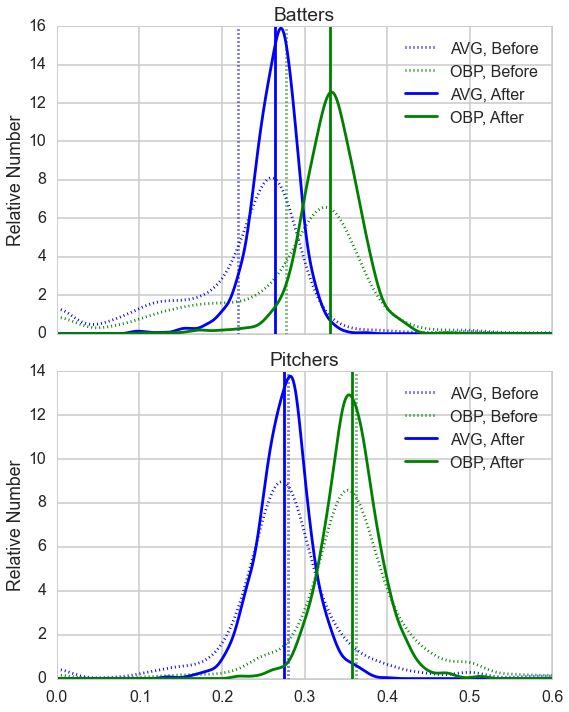

In [239]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=2, sharex=True)
axis=axes[0]
AVG, OBP = bigdf.groupby('bID')['ov_AVG'].agg(get_one), bigdf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b:', label='AVG, Before')
axis.axvline(AVG.mean(), color='b', ls=':')

axis.plot(x, kde_O(x), 'g:', label='OBP, Before')
axis.axvline(OBP.mean(), color='g', ls=':')

AVG, OBP = smalldf.groupby('bID')['ov_AVG'].agg(get_one), smalldf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG, After')
axis.axvline(AVG.mean(), color='b', ls='-')

axis.plot(x, kde_O(x), 'g-', label='OBP, After')
axis.axvline(OBP.mean(), color='g', ls='-')
axis.set_title("Batters")
axis.set_ylabel('Relative Number')
axis.legend()

axis=axes[1]
AVG, OBP = bigdf.groupby('pID')['ovp_AVG'].agg(get_one), bigdf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b:', label='AVG, Before')
axis.axvline(AVG.mean(), color='b', ls=':')

axis.plot(x, kde_O(x), 'g:', label='OBP, Before')
axis.axvline(OBP.mean(), color='g', ls=':')

AVG, OBP = smalldf.groupby('pID')['ovp_AVG'].agg(get_one), smalldf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG, After')
axis.axvline(AVG.mean(), color='b', ls='-')

axis.plot(x, kde_O(x), 'g-', label='OBP, After')
axis.axvline(OBP.mean(), color='g', ls='-')
axis.set_title("Pitchers")
axis.set_ylabel('Relative Number')
axis.legend()
plt.tight_layout()

By removing matchups where batter/pitchup faced eachother only a few times, and by removing batters/pitchers who had few total plate appearances, we have improved the total covering fraction of our data, and have removed the low-AVG tail among batter AVGs.

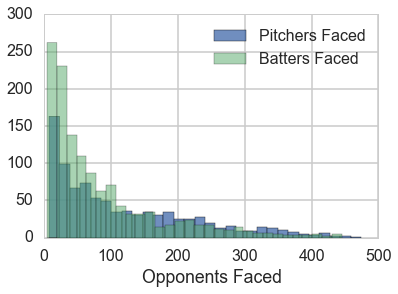

In [248]:
plt.hist(smalldf.groupby('bID').ov_FACED.agg(get_one), bins=30, alpha=0.8, label='Pitchers Faced')
plt.hist(smalldf.groupby('pID').ovp_FACED.agg(get_one), bins=30, alpha=0.5, label='Batters Faced')
plt.xlabel('Opponents Faced')
plt.legend();
plt.show()

##Split into Training/Test sets

We make sure that each batter has matchups in the training set. For most batters, we take 10 random matchups and put them in the test set, placing the rest in the training set. For batters with relatively few matchups, we leave at least 2/3 their total matchups in the training set.

In [277]:
trainlist=[]
testlist=[]
take=10 #At most 10 matchups in test set
for k, v in smalldf.groupby('bID'):
    train_rows, test_rows = train_test_split(v, test_size=min(take, len(v)/3))
    trainlist.append(train_rows)
    testlist.append(test_rows) 
traindf=pd.concat(trainlist)
testdf=pd.concat(testlist)

In [279]:
print('Size of datasets:\nTraining:\t%d\nTest:\t\t  %d'%(len(traindf), len(testdf)))

Size of datasets:
Training:	101481
Test:		  8207


Make sure that each pitcher was encountered in the training set. The number should be zero

In [280]:
masktest = np.in1d(testdf.pID, traindf.pID)
print np.sum(~masktest)

0


In [281]:
traindf.to_csv("data/training.csv", index=False)
testdf.to_csv("data/test.csv", index=False)

#4. Baseline Model

Reload train/validate/test sets from disk, in case want to start from this point in the code

In [282]:
traindf = pd.read_csv("data/training.csv")
testdf = pd.read_csv("data/test.csv")

In order to predict the batting average a batter will see against a new pitcher, we first develop a baseline model, which works as follows.

First, we compute the *global batting average* $\bar{Y}$ for all matchups in our training set. Then, we calculate the *bias* of each batter and pitcher. A batter's bias is how much his overall AVG deviates from the global AVG, and the pitcher's is the same. A good batter would have a positive bias, and a good pitcher would have a negative bias. Then, for a new matchup, our baseline model predicts that the matchup average is the global average plus the pitcher and batters biases:

For a matchup between batter $b$ (with overall AVG $\bar{Y_b}$) and pitcher $p$ (with overall AVG $\bar{Y_p}$), our predicted matchup average $\hat{Y}_{b,p}$ is:
$$\begin{align*}
\hat{Y}_{b,p} &= global\,AVG + batter\,bias + pitcher\,bias\\
&=\bar{Y} + (\bar{Y_b} - \bar{Y}) + (\bar{Y_p} - \bar{Y})\end{align*}$$

In [284]:
#Compute the global AVG
ybar = traindf.H.sum() / float(traindf.AB.sum())
print('Global AVG in Training Set: %.4f'%ybar)

Global AVG in Training Set: 0.2747


In [287]:
ubids=traindf.bID.unique()#unique-pitcher-ids
upids=traindf.pID.unique()#unique-batter-ids
print('%d pitchers, %d batters'%(len(upids),len(ubids)))

1297 pitchers, 910 batters


In [288]:
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [290]:
#Compute the per-batter and per-pitcher biases in the training set
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.ov_AVG.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.ovp_AVG.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

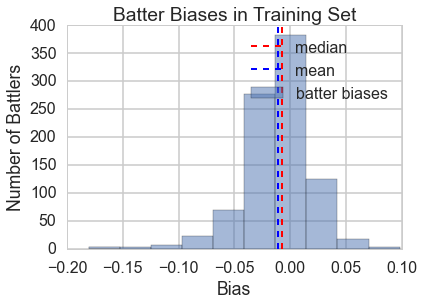

In [291]:
plt.hist(batter_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Battlers')
plt.title('Batter Biases in Training Set')
plt.axvline(np.median(batter_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(batter_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [295]:
predictions={'universal':ybar+np.zeros(len(testdf))}
predictions_valid={'universal':ybar+np.zeros(len(validatedf))}

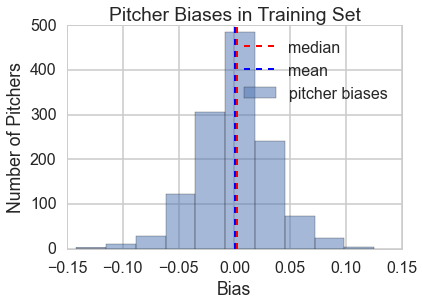

In [296]:
plt.hist(pitcher_biases.values(), alpha=0.5, label="pitcher biases");
plt.xlabel('Bias')
plt.ylabel('Number of Pitchers')
plt.title('Pitcher Biases in Training Set')
plt.axvline(x=np.median(pitcher_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(x=np.mean(pitcher_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [297]:
train_avgs={'mean':ybar, 'batters':batter_biases, 'pitchers':pitcher_biases}

Compute the baseline model predictions for the test set, using the mean and biases computed in the training set.

In [299]:
#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary

# #initializing list
# list_pred2=[]
# #for each row in validate df:
# for row in range(len(validatedf)):
#     batterid_val=validatedf.iloc[row]['bID'] #get the batter
#     pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
#     list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
#     predictions_valid["baseline"]=list_pred2 #add to dictionary
# print len(predictions_valid['baseline'])

In [300]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.sum(diff**2)/len(diff))

In [301]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline 0.133367151571


(0.0, 0.8)

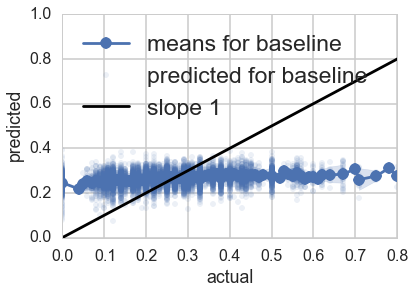

In [304]:
compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True);
plt.xlim([0.0, 0.8])

#5. Collaborative Filtering with KNN

In [1]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [4]:
traindf = pd.read_csv("data/training.csv")
testdf = pd.read_csv("data/test.csv")

#6. Ridge Regression

#7. Conclusions and Continuations